本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。学完本节，你将会掌握用 Keras实现循环网络的大部分内容。我们将在温度预测问题中介绍这三个概念。在这个问题中，数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数据来预测最后一个数据点 24小时之后的温度。这是一个相当有挑战性的问题，其中包含许多处理时间序列时经常遇到的困难。   

我们将会介绍以下三种技巧。

1. 循环  dropout（recurrent dropout）。这是一种特殊的内置方法，在循环层中使用    dropout来降低过拟合。   
2. 堆叠循环层（stacking  recurrent  layers）。这会提高网络的表示能力（代价是更高的计算负荷）。   
3. 双向循环层（bidirectional   recurrent layer）。将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题。   


### 6.3.1　温度预测问题

到目前为止，我们遇到的唯一一种序列数据就是文本数据，比如      IMDB数据集和路透社数据集。但除了语言处理，其他许多问题中也都用到了序列数据。在本节的所有例子中，我们将使用一个天气时间序列数据集，它由德国耶拿的马克思    •普朗克生物地球化学研究所的气象站记录。

在这个数据集中，每 10分钟记录  14个不同的量（比如气温、气压、湿度、风向等），其中包含多年的记录。原始数据可追溯到  2003年，但本例仅使用   2009—2016年的数据。这个数据集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一些数据（几天的数据点），可以预测 24小时之后的气温。

In [1]:
# wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# unzip jena_climate_2009_2016.csv.zip
# 观察耶拿天气数据集的数据
import os
data_dir = '/Users/yihuawang/Deeplearning/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname) # 读取文件
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))
# 共有 420551行数据（每行是一个时间步，记录了一个日期和14个与天气有关的值），还输出了下列表头。

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
# 将数据转换成一个Numpy数组
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

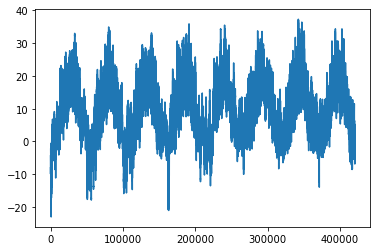

In [8]:
# 绘制温度时间序列

from matplotlib import pyplot as plt
temp = float_data[:, 1]  #温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
temp = float_data[:, 2]  #Tpot（单位：K）
plt.plot(range(len(temp)), temp)

temp = float_data[:, 3]  #Tdew（单位：degC）
plt.plot(range(len(temp)), temp)

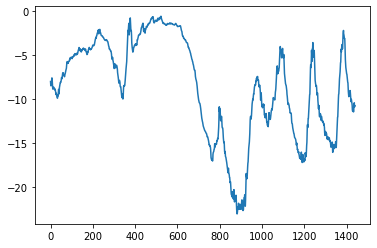

In [11]:
# 绘制前 10天的温度时间序列
plt.plot(range(1440), temp[:1440])

如果你想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？我们来寻找这个问题的答案。

### 6.3.2　准备数据

这个问题的确切表述如下：一个时间步是   10分钟，每steps个时间步采样一次数据，给定过去lookback个时间步之内的数据，能否预测 delay个时间步之后的温度？用到的参数值如下。

lookback = 720：给定过去  5天内的观测数据。   
steps = 6：观测数据的采样频率是每小时一个数据点。   
delay = 144：目标是未来  24小时之后的数据。   

开始之前，你需要完成以下两件事。  
1. 将数据预处理为神经网络可以处理的格式。这很简单。数据已经是数值型的，所以不需要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于     20到   +30之间，但气压大约在 1000毫巴上下）。你需要对每个时间序列分别做标准化，让它们在相似的范围内都取较小的值。  

2. 编写一个  Python生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第  N个样本和第 N+1个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本。

In [3]:
# 预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。
# 我们将使用前200 000个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
# 生成时间序列样本及其目标的生成器
# data：浮点数数据组成的原始数组
# lookback：输入数据应该包括过去多少个时间步。
# delay：目标应该在未来多少个时间步之后。
# data数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试
# shuffle：是打乱样本，还是按顺序抽取样本
# batch_size：每个批量的样本数。
# step：数据采样的周期（单位：时间步）。我们将其设为  6，为的是每小时抽取一个数据点。

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
    else:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        
    samples = np.zeros((len(rows),
                    lookback // step,
                    data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
        indices = range(rows[j] - lookback, rows[j], step)
        samples[j] = data[indices]
        targets[j] = data[rows[j] + delay][1]
    yield samples, targets


下面，我们使用这个抽象的generator函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前200 000个时间步，验证生成器读取随后的  100 000个时间步，测试生成器读取剩下的时间步。

In [5]:
# 准备训练生成器、验证生成器和测试生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000, # 前200,000个
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001, #前200,001个
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size # 为了查看在验证集中，需要从val_gen中抽取多少次

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size # 为了查看整个测试集中，需要从test_gen中抽取多少次

### 6.3.3　一种基于常识的、非机器学习的基准方法
开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含90%的类别  A实例和  10%的类别   B实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别“A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于   90%时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。   

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测 24小时后的温度等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。   
np.mean(np.abs(preds - targets))

In [ ]:
# 计算符合常识的基准方法的 MAE

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()



得到的 MAE为  0.29。因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为 0.29×temperature_std摄氏度，即 2.57℃。

In [ ]:
celsius_mae = 0.29 * std[1]

### 6.3.4　一种基本的机器学习方法

在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究复杂且计算代价很高的模型（比如 RNN）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

代码清单 6-37给出了一个密集连接模型，首先将数据展平，然后通过两个Dense层并运行。注意，最后一个 Dense层没有使用激活函数，这对于回归问题是很常见的。我们使用   MAE作为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。


In [ ]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') # 因为是回归，所以不需要激活函数
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.5　第一个循环网络基准
第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念。我们来看一下数据本来的样子：它是一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同。   

我们将使用 Chung等人在  2014年开发的GRU层，而不是上一节介绍的LSTM层。门控循环单元（GRU，gated recurrent  unit）层的工作原理与 LSTM相同。但它做了一些简化，因此运行的计算代价更低（虽然表示能力可能不如 LSTM）。机器学习中到处可以见到这种计算代价与表示能力之间的折中。   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) # 构建一个GRU
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                       steps_per_epoch=500,
                       epochs=20,
                       validation_data=val_gen,
                       validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
#显示了模型结果。效果好多了！远优于基于常识的基准方法。这证明了机器学习的价值，也证明了循环网络与序列展平的密集网络相比在这种任务上的优势。
# 新的验证 MAE约为 0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为2.35℃。与最初的误差2.57℃相比，这个结果确实有所提高，但可能仍有改进的空间。

### 6.3.6　使用循环 dropout来降低过拟合
从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过降低过拟合的一种经典技术——    dropout，即将某一层的输入单元随机设为 0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中如何正确地使用dropout，这并不是一个简单的问题。人们早就知道，在循环层前面应用  dropout，这种正则化会妨碍学习过程，而不是有所帮助。2015年，在关于贝叶斯深度学习的博士论文中，Yarin     Gal确定了在循环网络中使用 dropout的正确方法：对每个时间步应该使用相同的  dropout掩码（dropoutmask，相同模式的舍弃单元），而不是让 dropout掩码随着时间步的增加而随机变化。此外，为了对GRU、LSTM等循环层得到的表示做正则化，应该将不随时间变化的     dropout掩码应用于层的内部循环激活（叫作循环 dropout掩码）。对每个时间步使用相同的  dropout掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的 dropout掩码则会破坏这个误差信号，并且不利于学习过程。   

Yarin Gal使用  Keras开展这项研究，并帮助将这种机制直接内置到    Keras循环层中。Keras的每个循环层都有两个与  dropout相关的参数：一个是 dropout，它是一个浮点数，指定该层输入单元的 dropout比率；另一个是 recurrent_dropout，指定循环单元的  dropout比率。我们向GRU层中添加    dropout和循环  dropout，看一下这么做对过拟合的影响。因为使用     dropout正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的 2倍

In [ ]:
# 训练并评估一个使用 dropout正则化的基于GRU的模型

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2, # 参数一
                     recurrent_dropout=0.2, # 参数二
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                     steps_per_epoch=500,
                     epochs=40,
                     validation_data=val_gen,
                     validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#成功！前30个轮次不再过拟合。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

### 6.3.7　循环层堆叠

模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用   dropout）。只要过拟合不是太严重，那么很可能是容量不足的问题。   

增加网络容量的通常做法是增加每层单元数或增加层数。循环层堆叠（recurrent  layer stacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是    7个大型LSTM层的堆叠——这个架构很大。   

在 Keras中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个    3D张量），而不是只返回最后一个时间步的输出。这可以通过指定return_sequences=True来实现。


In [ ]:
# 训练并评估一个使用 dropout正则化的堆叠 GRU模型


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,  # 指定输出完整张量
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                     steps_per_epoch=500,
                     epochs=40,
                     validation_data=val_gen,
                     validation_steps=val_steps)

# 可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论。

# 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。但这么做的计算成本很高。
# 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小。

### 6.3.8　使用双向  RNN
本节介绍的最后一种方法叫作双向    RNN（bidirectional  RNN）。双向 RNN是一种常见的RNN变体，它在某些任务上的性能比普通   RNN更好。它常用于自然语言处理，可谓深度学习对自然语言处理的瑞士军刀。  

RNN特别依赖于顺序或时间，  RNN按顺序处理输入序列的时间步，而打乱时间步或反转时间步会完全改变 RNN从序列中提取的表示。正是由于这个原因，如果顺序对问题很重要（比如温度预测问题），RNN的表现会很好。双向   RNN利用了  RNN的顺序敏感性：它包含两个普通 RNN，比如你已经学过的 GRU层和LSTM层，每个   RN分别沿一个方向对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，双向RNN能够捕捉到可能被单向  RNN忽略的模式。   


值得注意的是，本节的 RNN层都是按时间正序处理序列（更早的时间步在前），这可能是一个随意的决定。至少，至今我们还没有尝试质疑这个决定。如果 RNN按时间逆序处理输入序列（更晚的时间步在前），能否表现得足够好呢？我们在实践中尝试一下这种方法，看一下会发生什么。你只需要编写一个数据生成器的变体，将输入序列沿着时间维度反转（即将最后一行代码替换为yield  samples[:, ::-1, :], targets）。本节第一个实验用到了一个单GRU层的网络，我们训练一个与之相同的网络，得到的结果如图 6-24所示。

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        

In [ ]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

逆序 GRU的效果甚至比基于常识的基准方法还要差很多，这说明在本例中，按时间正序处理对成功解决问题很重要。这非常合理：GRU层通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力（这也是基于常识的基准方法非常强大的原因）。因此，按时间正序的模型必然会优于时间逆序的模型。重要的是，对许多其他问题（包括自然语言）而言，情况并不是这样：直觉上来看，一个单词对理解句子的重要性通常并不取决于它在句子中的位置。

In [ ]:
# 使用逆序序列训练并评估一个LSTM

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

模型性能与正序 LSTM几乎相同。值得注意的是，在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的 RNN学到的表示不同于在原始序列上学到的表示，正如在现实世界中，如果时间倒流（你的人生是第一天死去、最后一天出生），那么你的心智模型也会完全不同。在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是集成（ensembling）方法背后的直觉，我们将在第 7章介绍集成的概念。

双向 RNN正是利用这个想法来提高正序 RNN的性能。它从两个方向查看数据（见图  6-25），从而得到更加丰富的表示，并捕捉到仅使用正序 RNN时可能忽略的一些模式。   

在 Keras中将一个双向  RNN实例化，我们需要使用 Bidirectional层，它的第一个参数是一个循环层实例。Bidirectional对这个循环层创建了第二个单独实例，然后使用一个实例按正序处理输入序列，另一个实例按逆序处理输入序列。我们在  IMDB情感分析任务上来试一下这种方法

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32))) # 添加该层
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

这个模型的表现比上一节的普通 LSTM略好，验证精度超过  89%。这个模型似乎也很快就开始过拟合，这并不令人惊讶，因为双向层的参数个数是正序 LSTM的  2倍。添加一些正则化，双向方法在这个任务上可能会有很好的表现。

In [ ]:
# 训练一个双向GRU

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
        steps_per_epoch=500,
        epochs=40,
        validation_data=val_gen,
        validation_steps=val_steps)

这个模型的表现与普通 GRU层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）。

### 6.3.9　更多尝试
为了提高温度预测问题的性能，你还可以尝试下面这些方法。  

1. 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的。  

2. 调节RMSprop优化器的学习率。  

3. 尝试使用LSTM层代替GRU层。  

4. 在循环层上面尝试使用更大的密集连接回归器，即更大的Dense层或Dense层的堆叠。   

5. 不要忘记最后在测试集上运行性能最佳的模型（即验证   MAE最小的模型）。否则，你开发的网络架构将会对验证集过拟合。

### 6.3.10 　小结

1. 我们在第  4章学过，遇到新问题时，最好首先为你选择的指标建立一个基于常识的基准。如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。  

2. 在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有意义的。有时简单模型就是你的最佳选择。  
3. 如果时间顺序对数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据展平的模型相比，其性能要更好。   
4. 想要在循环网络中使用    dropout，你应该使用一个不随时间变化的    dropout掩码与循环dropout掩码。这二者都内置于  Keras的循环层中，所以你只需要使用循环层的dropout和recurrent_dropout参数即可。   
5. 与单个  RNN层相比，堆叠  RNN的表示能力更加强大。但它的计算代价也更高，因此不一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。   
6. 双向  RNN从两个方向查看一个序列，它对自然语言处理问题非常有用。但如果在序列数据中最近的数据比序列开头包含更多的信息，那么这种方法的效果就不明显。  